<h1><b>Import Modules</b></h1>

In [2]:
import pandas as pd
import numpy as np
from math import pi
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

random_seed=42

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h1><b>Reading Data</b></h1>

In [3]:
tr=['warehouse','date','orders','id']
ts=['warehouse','date','id']

In [4]:
train=pd.read_csv('train.csv',usecols=tr)
test=pd.read_csv('test.csv',usecols=ts)

<h3><b>Convertion to Time Series </b></h3>

In [5]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

In [6]:
for dataset in (train,test):
    dataset['Datetime'] = pd.to_datetime(dataset['date'])
    dataset['Day'] = dataset.Datetime.dt.day
    dataset['Month'] = dataset.Datetime.dt.month
    dataset['Year'] = dataset.Datetime.dt.year
    dataset['DayOfWeek'] = dataset.Datetime.dt.dayofweek
    dataset['DayOfYear'] = dataset.Datetime.dt.dayofyear
    dataset['weekday'] = dataset.Datetime.dt.weekday
    dataset['is_year_start'] = dataset.Datetime.dt.is_year_start
    dataset['is_year_end'] = dataset.Datetime.dt.is_year_end
    dataset['is_leap_year'] = dataset.Datetime.dt.is_leap_year
    dataset['is_month_start'] = dataset.Datetime.dt.is_month_start
    dataset['is_month_end'] = dataset.Datetime.dt.is_month_end
    dataset['daysinmonth'] = dataset.Datetime.dt.daysinmonth
    dataset['Dayis_quarter_start'] = dataset.Datetime.dt.is_quarter_start
    dataset['is_quarter_end'] = dataset.Datetime.dt.is_quarter_end
    dataset.drop(['Datetime','date'],axis=1,inplace=True)

<h1><b>EDA</b></h1>

<Axes: >

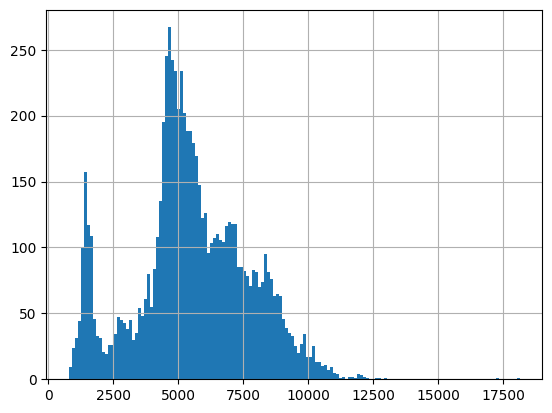

In [14]:
# Target Histogram
train['orders'].hist(bins = 150)

[]

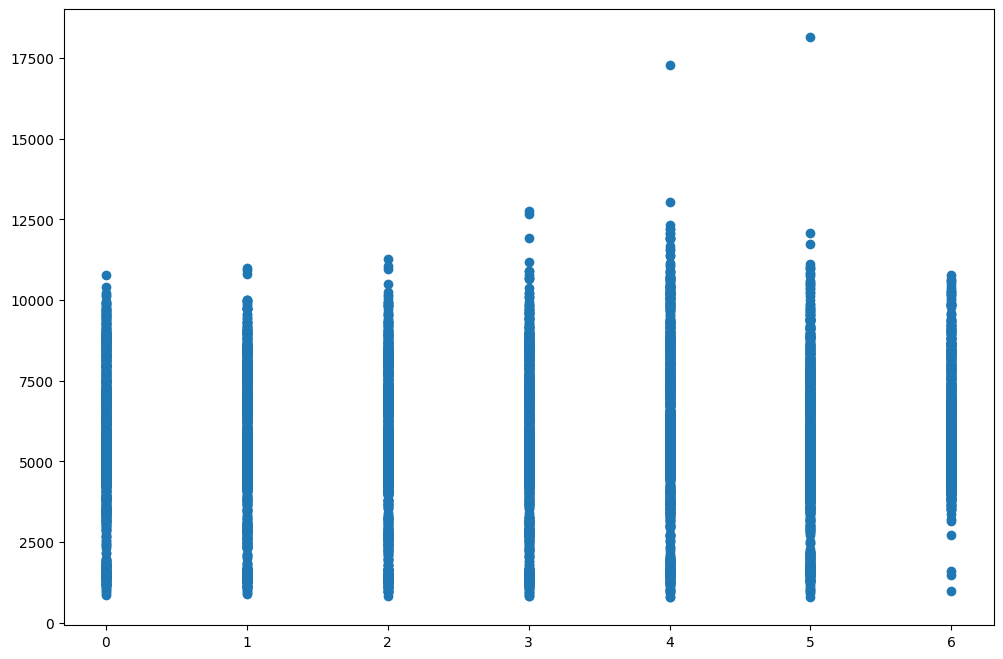

In [11]:
#Sales_DayOfWeek
plt.figure(figsize=(12, 8))
plt.scatter(train["DayOfWeek"],train["orders"])
plt.plot()

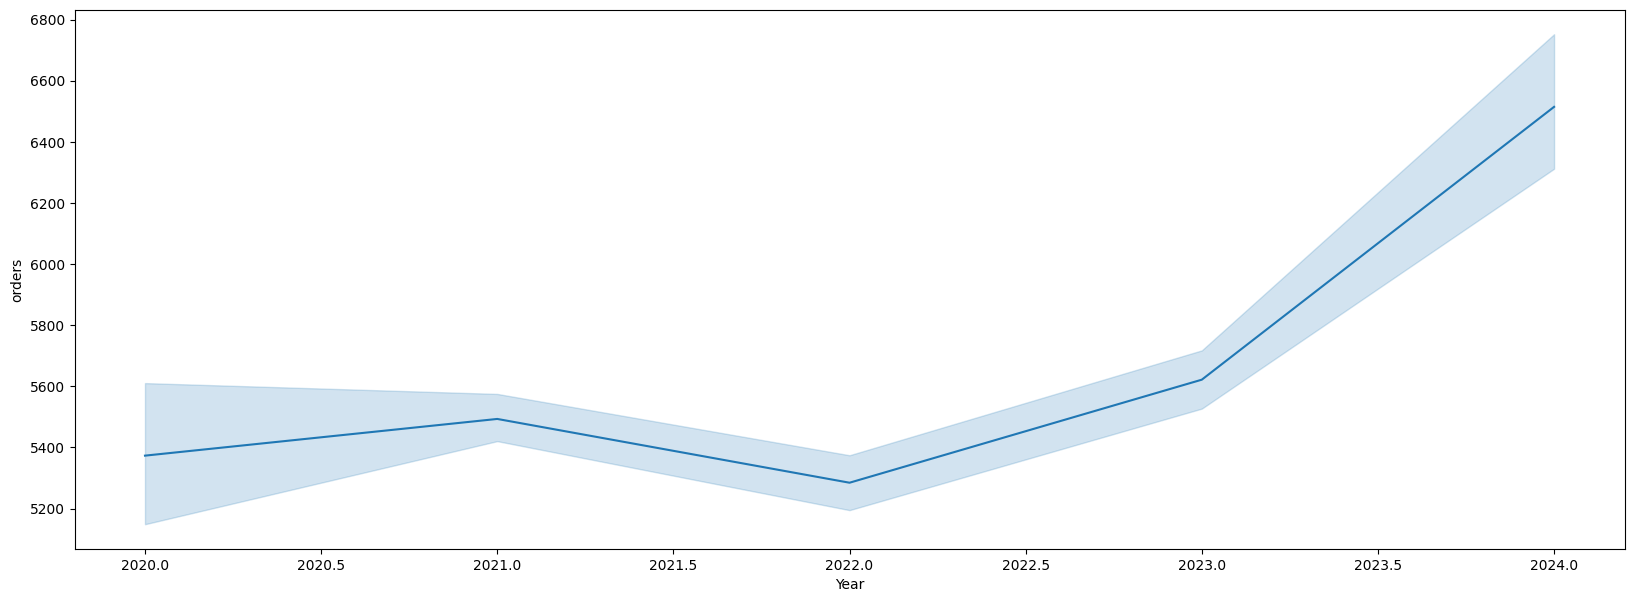

In [12]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
sns.lineplot(x=train.Year, y="orders", data=train)
plt.show()

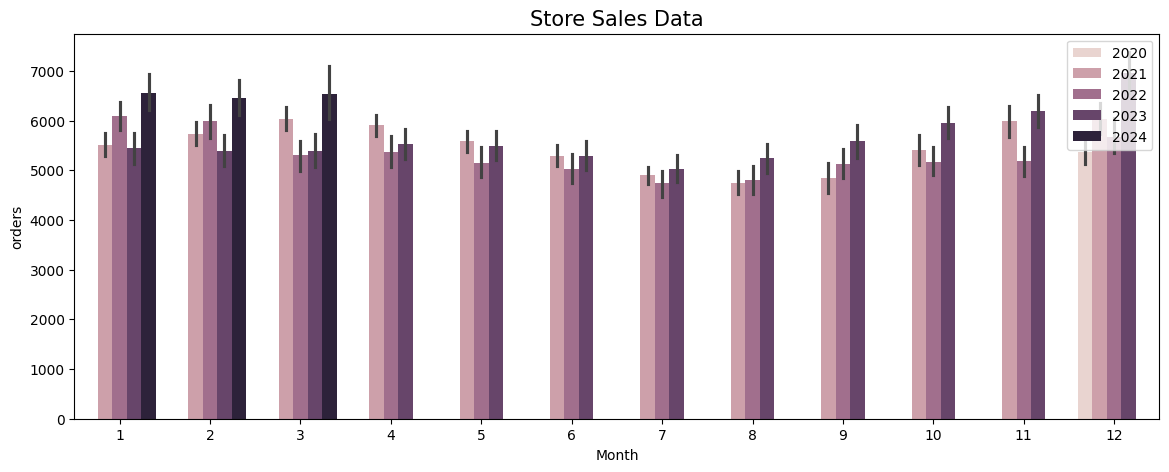

In [13]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 5)
a = sns.barplot(x="Month", y="orders",hue = 'Year',data=train)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

# Feature Engineering and Preprocessing

In [ ]:
train['friday']=train['DayOfWeek']==4
test['friday']=test['DayOfWeek']==4

In [ ]:
# Encoding Preprocess 
feats=['warehouse','friday']
le=LabelEncoder()
df=train
dfs=test
for f in feats :
    le.fit(df[f])
    train[f]=le.transform(train[f])
    le.fit(dfs[f])
    test[f]=le.transform(test[f])

In [ ]:
#sin and cosin features 
train['month_sin'] = train['Month'] * np.sin(2 * pi * train['Month'])
train['month_cos'] = train['Month'] * np.cos(2 * pi * train['Month'])
train['day_sin'] = train['Day'] * np.sin(2 * pi * train['Day'])
train['day_cos'] = train['Day'] * np.cos(2 * pi * train['Day'])
train['year_sin'] = np.sin(2 * pi * train["DayOfYear"])
train['year_cos'] = np.cos(2 * pi * train['DayOfYear'])
test['month_sin'] = test['Month'] * np.sin(2 * pi * test['Month'])
test['month_cos'] = test['Month'] * np.cos(2 * pi * test['Month'])
test['day_sin'] = test['Day'] * np.sin(2 * pi * test['Day'])
test['day_cos'] = test['Day'] * np.cos(2 * pi * test['Day'])
test['year_sin'] = np.sin(2 * pi * test["DayOfYear"])
test['year_cos'] = np.cos(2 * pi * test['DayOfYear'])

### <b>Seprate Train and Test Cities </b>

In [ ]:
P_1=train[:1193]
B_1=train[1193:2386]
P_2=train[2386:3579]
P_3=train[3579:4772]
Mu_1=train[4772:5557]
Fr_1=train[5557:6186]
Bud_1=train[6186:]

In [879]:
print(f'train shape ={train.shape}')
print(5*'- -')
print(f'all shapes ={P_1.shape + P_2.shape + P_3.shape + Mu_1.shape + Fr_1.shape + Bud_1.shape + B_1.shape}')

train shape =(7340, 30)
- -- -- -- -- -
all shapes =(1193, 30, 1193, 30, 1193, 30, 785, 30, 629, 30, 1154, 30, 1193, 30)


In [880]:
P_1_=test[:61]
B_1_=test[61:122]
P_2_=test[122:183]
P_3_=test[183:244]
Mu_1_=test[244:292]
Fr_1_=test[292:340]
Bud_1_=test[340:]

In [881]:
print(f'train shape ={test.shape}')
print(5*'- -')
print(f'all shapes ={P_1_.shape + P_2_.shape + P_3_.shape + Mu_1_.shape + Fr_1_.shape + Bud_1_.shape + B_1_.shape}')

train shape =(397, 29)
- -- -- -- -- -
all shapes =(61, 29, 61, 29, 61, 29, 48, 29, 48, 29, 57, 29, 61, 29)


<h1><b>Model Training and Infernce</b></h1>

In [893]:
def cv(data,test):
    X=train.drop("orders",axis=1).values
    y=train["orders"].values
    scores=[]
    kf=TimeSeriesSplit(n_splits=5)
    estimators=[
                               ('xgb',GradientBoostingRegressor(random_state=random_seed)),
                               ('xga',ExtraTreesRegressor(random_state=random_seed)),
                               ('lgbm',LGBMRegressor(random_state=random_seed)),
                               ('rf',RandomForestRegressor(random_state=random_seed)),
                               ('hgb',HistGradientBoostingRegressor(random_state=random_seed,)),
                               ]
    for train_index,test_index in kf.split(X,y):
        X_train,y_train=X[train_index],y[train_index]
        X_test,y_test=X[test_index],y[test_index]
        xg=VotingRegressor(estimators=estimators)
        xg.fit(X_train,y_train)
        y_pred=xg.predict(X_test)
        xg.fit(X,y)
    test['orders']=xg.predict(test)

    return scores.append(mean_absolute_percentage_error(y_pred,y_test) )

In [894]:
print(pd.DataFrame({'The mean of total data':[cv(P_1,P_1_),cv(P_2,P_2_),
                    cv(P_3,P_3_),cv(B_1,B_1_),cv(Mu_1,Mu_1_),cv(Fr_1,Fr_1_),cv(Bud_1,Bud_1_)]}))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 23
[LightGBM] [Info] Start training from score 8476.468571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 26
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_9106/2996778865.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 23
[LightGBM] [Info] Start training from score 8476.468571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 26
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_9106/2996778865.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 23
[LightGBM] [Info] Start training from score 8476.468571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 26
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_9106/2996778865.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 23
[LightGBM] [Info] Start training from score 8476.468571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 26
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_9106/2996778865.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 23
[LightGBM] [Info] Start training from score 8476.468571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 26
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_9106/2996778865.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 23
[LightGBM] [Info] Start training from score 8476.468571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 26
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train se

/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_9106/2996778865.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 23
[LightGBM] [Info] Start training from score 8476.468571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 26
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/logman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_9106/2996778865.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [896]:
P_1_=P_1_.reset_index().rename(columns={'id': 'id'})
P_2_=P_2_.reset_index().rename(columns={'id': 'id'})
P_3_=P_3_.reset_index().rename(columns={'id': 'id'})
B_1_=B_1_.reset_index().rename(columns={'id': 'id'})
Mu_1_=Mu_1_.reset_index().rename(columns={'id': 'id'})
Bud_1_=Bud_1_.reset_index().rename(columns={'id': 'id'})
Fr_1_=Fr_1_.reset_index().rename(columns={'id': 'id'})

<h1><b>Submission</b></h1>

In [897]:
submission=pd.concat([P_1_,B_1_,P_2_,P_3_,Mu_1_,Fr_1_,Bud_1_],axis=0)

In [898]:
submission[['id','orders']].to_csv("sub.csv",index=False)